# Clustering

When you reach a certain length of text to summarize, the other methods become too expensive or are not able to summarize well enough. We need to find a way to extract all the important parts of large texts like books or very big documents, and create a summary from them.

Some simple ways to avoid using all the chunks for summarization is either randomly selecting chunks, or spacing out which chunks are selected. But what if we miss out on an important part of the text while doing this?

A solution is K-means clustering, where each chunk is embedded, and then clusters are formed based on semantic meaning of those chunks. Then a summary is formed from each cluster, hopefully netting us a more accurate summary of huge texts.

Another advantage is the amount of requests sent to the API. While Map Reduction sends many requests, clustering will send only one request, saving a lot of money.

In [1]:
from dotenv import load_dotenv
from utils import read_files, split_document_by_tokens
from pathlib import Path

import os

load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
documents = read_files(Path('./content/nord-universitet'))
doc = documents[0]

In [4]:
from langchain.schema import Document

content = ""

for doc in documents:
    content += doc.page_content

doc = Document(page_content=content)

Set up our LLM

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-3.5-turbo-0125")

We check how many tokens are in our book. Dracula, the book we will summarize, has 216728 tokens. Yikes!

Using map reduction or stuffing on this text would cause a lot of tokens to be sent to the LLM, hurting our wallet.

In [6]:
num_tokens = llm.get_num_tokens(doc.page_content)
print(f'Our text has {num_tokens} tokens')

Our text has 137133 tokens


So, we need to start with splitting our book into chunks. To do this I will split by tokens.

In [8]:
split_docs = split_document_by_tokens([doc], chunk_size=2000, overlap=200)
print(f'Now our document is split up into {len(split_docs)} documents')

Now our document is split up into 93 documents


### Embedding

Clustering relies on embeddings to work. Embeddings are vector representations of text, so that LLMs can work with them (LLMs don't understand human readable text, they understand numbers).
Therefore we need to create embeddings from our documents.

In [9]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_API_KEY, model='text-embedding-3-small')

vectors = embeddings.embed_documents([doc.page_content for doc in split_docs])

### Clustering

There are many different clustering algorithms to choose from. Let's try a few of them. We'll start with KMeans clustering.

In [10]:
from sklearn.cluster import KMeans

num_clusters = 11

kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

In [11]:
kmeans.labels_

array([ 2, 10, 10, 10, 10,  2,  2,  2,  3,  2,  2,  2,  2,  2,  2, 10, 10,
        4,  4,  4,  4,  0,  0,  0,  0,  7,  7,  7,  4,  4,  7,  7,  7,  4,
        4,  6,  6,  6,  7,  7, 10, 10, 10,  4,  4,  4,  4,  4,  4,  7,  7,
        7,  7,  4,  6,  4,  3,  3,  3,  3,  8,  8,  8,  8,  8,  8,  8,  8,
        1,  3,  3,  3,  8,  2,  8,  9,  9,  9,  9,  9,  5,  5,  5,  5,  5,
        5,  5,  1,  1,  1,  1,  2, 10])

Time to visualize

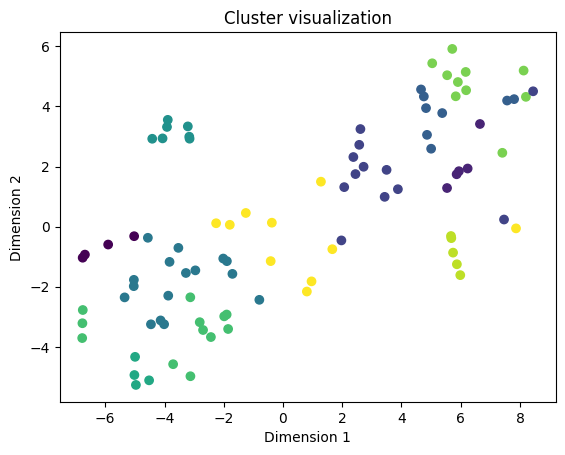

In [12]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

tsne = TSNE(n_components=2, random_state=42)
vectors = np.array(vectors)
reduced_data_tsne = tsne.fit_transform(vectors)

plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Cluster visualization')
plt.show()

Get the vectors which are closest to the center of the cluster

In [13]:
closest_indices = []

for i in range(num_clusters):
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    closest_index = np.argmin(distances)
    closest_indices.append(closest_index)

Then sort them so that they are processed in order

In [14]:
selected_indices = sorted(closest_indices)

In [15]:
selected_docs = [split_docs[doc] for doc in selected_indices]
selected_docs

[Document(page_content=' for ja, delvis eller nei under ”Leverandørens oppfyllelse”. Merk at på A-krav (absolutte krav), er det kun anledning til å svare ja eller nei. \n\nHenvisning til relevant dokumentasjon og ev. ytterligere kommentarer skal gjøres i kolonnen ”Kommentar”. Det vises til at Leverandøren plikter å dokumentere at han oppfyller de krav som er satt. Ev. manglende dokumentasjon vil medføre at kravet anses som ikke oppfylt.\n\nOppdragsgiver gjør oppmerksom på at det også er en kravtabell i SSA-V Bilag 1: Kundens kravspesifikasjon (krav til vedlikeholdstjenesten).\n\n\nKrav nr. Prioritet Beskrivelse 1 Funksjonelle krav 1.1 A Universell utforming CMS skal egne seg godt til bygging av nettsteder som er tilgjengelige for mennesker med nedsatt funksjonsevne. Løsningen skal tilfredsstille de gjeldende krav og retningslinjer til universell utforming for offentlige virksomheter. Løsningen skal minimum følge WCAG 2.1 nivå AA og WAD. Offentlig sektor skal følge 14 nye krav fra og me

In [16]:
from langchain import PromptTemplate

map_prompt = """
You will be given a piece of a larger text. This piece of text will be enclosed in triple backticks (```).
Your job is to give a summary of this piece of text so that the reader will have a full understanding of what the text is about.
Your response should be at least three paragraphs and fully encompass what was written in the piece of text.

```{text}```
FULL SUMMARY:
"""

map_prompt_template = PromptTemplate(template=map_prompt, input_variables=["text"])

In [17]:
from langchain.chains.summarize import load_summarize_chain

map_chain = load_summarize_chain(llm=llm, chain_type="stuff", prompt=map_prompt_template)

summary_list = []

for i, doc in enumerate(selected_docs):
    chunk_summary = map_chain.run([doc])
    summary_list.append(chunk_summary)

    print(f'Summary #{i} (chunk #{selected_indices[i]}) - Preview: {chunk_summary[:250]} \n')

c:\Users\12nor\Documents\Development\dat255-course-project\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


Summary #0 (chunk #10) - Preview: The piece of text provided outlines specific requirements for a CMS (Content Management System) in a procurement process. The text includes a table listing different priority levels of functional requirements for the CMS, such as universal design, re 

Summary #1 (chunk #19) - Preview: The piece of text provided outlines general terms and conditions for the delivery of software and related services to a customer. It covers various aspects such as the customer's responsibility when using open-source software, the supplier's breach o 

Summary #2 (chunk #22) - Preview: The piece of text outlines the responsibilities of the supplier in ensuring that the software delivery meets the requirements of the agreement. The supplier is accountable for ensuring that the delivery works with the customer's existing solution as  

Summary #3 (chunk #41) - Preview: The piece of text outlines the requirements and responsibilities for a service provider in terms of deliv

In [18]:
llm4 = ChatOpenAI(openai_api_key=OPENAI_API_KEY, model="gpt-4-turbo-preview")

In [19]:
from langchain.schema import Document
summaries = "\n".join(summary_list)

summaries = Document(page_content=summaries)

print(f'All your summaries together are {llm.get_num_tokens(summaries.page_content)} tokens')

All your summaries together are 3129 tokens


In [20]:
combine_prompt = """
You will now be given a series of summaries from a larger text. The summaries will be enclosed in triple backticks(```).
Your goal is to give a summary of what happened in the greater piece of text.
The reader should be able to grasp what the full text is about from your summary.

```{text}```
SUMMARY:
"""

combine_prompt_template = PromptTemplate(template=combine_prompt, input_variables=["text"])

In [21]:
reduce_chain = load_summarize_chain(llm=llm4, chain_type="stuff", prompt=combine_prompt_template)

output = reduce_chain.run([summaries])

In [22]:
print(output)

The comprehensive text encompasses several interconnected themes focusing on the procurement, implementation, and management of content management systems (CMS) and software solutions, particularly within an educational institution setting, likely Nord University. It details the requirements and standards for selecting a CMS, emphasizing features like accessibility, responsive design, multi-language support, user-friendly interfaces, and efficient document and link management. It also outlines the terms and conditions for software delivery and related services, including development, customization, training, and maintenance services, highlighting the supplier's responsibilities in ensuring the software integrates seamlessly with existing systems, meets quality assurance standards, and undergoes thorough testing and acceptance procedures by the customer.

Additionally, the text covers maintenance services, stressing the importance of error correction, updates, uptime, security, and priv